# Hệ thống đề xuất: sử dụng phương pháp Collaborative filtering trên tập dữ liệu MovieLens 

### Nội dung Notebook:

#### -  User-based (user-user) collaborative filtering 
    
#### - Item-based (item-item) collaborative filtering 
    
#### - Đánh giá
    

## User-based collaborative filtering

### Load file dữ liệu và thư viện:

In [2]:
# import libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# loading csv file into pandas dataframe

my_path = "/content/drive/MyDrive/machinelearning/recommendation/ml-latest-small/"

ratings = pd.read_csv(my_path + 'ratings.csv')
movies = pd.read_csv(my_path + 'movies.csv')


#### Quan sát tổng quan về dữ liệu:

In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
ratings.tail()

,userId,movieId,rating,timestamp
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352
100835,610,170875,3.0,1493846415


In [ ]:
ratings.shape

(100836, 4)

In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


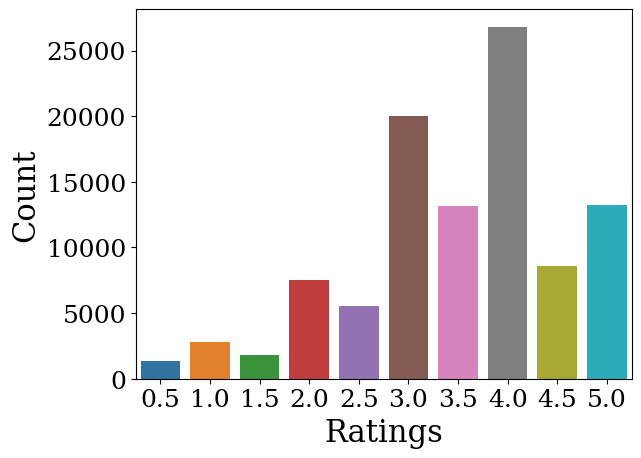

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 8))
sns.countplot(x=ratings["rating"])

plt.xlabel('Ratings', fontsize=22, fontfamily='serif')
plt.ylabel('Count', fontsize=22, fontfamily='serif')

plt.xticks(fontsize=18, fontfamily='serif')
plt.yticks(fontsize=18, fontfamily='serif')

plt.show()

### Chia dữ liệu thành 2 tập train và test:

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(ratings, test_size = 0.30, random_state = 42)

print(X_train.shape)
print(X_test.shape)

(70585, 4)
(30251, 4)


In [5]:
# pivot ratings:

user_data = X_train.pivot(index = 'userId', columns = 'movieId', values = 'rating').fillna(0)
user_data.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,190221,191005,193565,193571,193573,193579,193581,193583,193585,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Tạo một bản sao cho tập dữ liệu train và test
Những bộ dữ liệu này sẽ được sử dụng để dự đoán và đánh giá.

Dummy_train sẽ được sử dụng để dự đoán những bộ phim chưa được user rate. Để bỏ qua những bộ phim được user rate, chúng tôi sẽ đánh dấu nó là 0 trong quá trình dự đoán. Những bộ phim không được user rate được đánh dấu là 1 để dự đoán.

Dummy_test sẽ được sử dụng để đánh giá. Để đánh giá, chúng tôi sẽ chỉ đưa ra dự đoán về những bộ phim được user đã rate. Vì vậy, nó được đánh dấu là 1, ngược lại với dummy_train

In [6]:
# copy tập train and test datasets
dummy_train = X_train.copy()
dummy_test = X_test.copy()

dummy_train['rating'] = dummy_train['rating'].apply(lambda x: 0 if x > 0 else 1)
dummy_test['rating'] = dummy_test['rating'].apply(lambda x: 1 if x > 0 else 0)

In [7]:
# Những phim không được user rate đánh dấu là 1 dùng để dự đoán:
dummy_train = dummy_train.pivot(index = 'userId', columns = 'movieId', values = 'rating').fillna(1)

# Phim không được user rate là 0 để đánh giá 
dummy_test = dummy_test.pivot(index ='userId', columns = 'movieId', values = 'rating').fillna(0)

In [ ]:
dummy_train.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,190221,191005,193565,193571,193573,193579,193581,193583,193585,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
dummy_test.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,187595,189043,189111,189333,189547,189713,190213,190219,193567,193587
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### User-User Similarity matrix

#### Using Cosine similarity

In [8]:
from sklearn.metrics.pairwise import cosine_similarity

# Ma trận độ tương đồng của user sử dụng độ tương đồng Cosine làm thước đo độ tương đồng giữa các User
user_similarity = cosine_similarity(user_data)
user_similarity[np.isnan(user_similarity)] = 0           #chuyển các giá trị NaN = 0
print(user_similarity)
print(user_similarity.shape)

[[1.         0.01799262 0.02914591 ... 0.22586534 0.12184689 0.13241346]
 [0.01799262 1.         0.         ... 0.04299081 0.03472882 0.0625667 ]
 [0.02914591 0.         1.         ... 0.00378273 0.         0.02382229]
 ...
 [0.22586534 0.04299081 0.00378273 ... 1.         0.10982639 0.21962266]
 [0.12184689 0.03472882 0.         ... 0.10982639 1.         0.05416081]
 [0.13241346 0.0625667  0.02382229 ... 0.21962266 0.05416081 1.        ]]
(610, 610)


###  Dự đoán rate của User trên các phim:

In [9]:
user_predicted_ratings = np.dot(user_similarity, user_data)
user_predicted_ratings

array([[8.52008912e+01, 3.99290227e+01, 2.08165173e+01, ...,
        2.81820351e-02, 2.81820351e-02, 1.57425084e-01],
       [2.45531356e+01, 1.05987273e+01, 2.94172315e+00, ...,
        8.74389309e-02, 8.74389309e-02, 4.49741734e-01],
       [4.22670774e+00, 2.11463396e+00, 9.59320674e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [9.49265311e+01, 4.92867089e+01, 2.12555470e+01, ...,
        2.51644930e-02, 2.51644930e-02, 5.92666313e-01],
       [7.50962548e+01, 3.56578151e+01, 1.17138113e+01, ...,
        0.00000000e+00, 0.00000000e+00, 6.43083908e-02],
       [7.67153155e+01, 3.67625117e+01, 1.11564580e+01, ...,
        2.61466866e-01, 2.61466866e-01, 8.03583319e-01]])

In [ ]:
user_predicted_ratings.shape

(610, 8566)

Tôi không muốn đề xuất cùng một bộ phim mà user đã xem, mà chỉ quan tâm đến những bộ phim không được user đánh giá, nên tôi sẽ bỏ qua những bộ phim đã được user đánh giá.


In [10]:
user_final_ratings = np.multiply(user_predicted_ratings, dummy_train)
user_final_ratings.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,190221,191005,193565,193571,193573,193579,193581,193583,193585,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,0.000000,39.929023,0.000000,1.220732,10.483532,0.000000,14.082187,2.605186,4.111435,47.981999,...,0.083324,0.036234,0.028182,0.032208,0.032208,0.028182,0.032208,0.028182,0.028182,0.157425
2,24.553136,10.598727,2.941723,0.085473,2.773060,10.458197,2.308815,0.523106,0.588578,11.698251,...,0.054182,0.112421,0.087439,0.099930,0.099930,0.087439,0.099930,0.087439,0.087439,0.449742
3,4.226708,2.114634,0.959321,0.066644,0.308448,2.855740,0.518991,0.105484,0.190006,2.550762,...,0.008707,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,50.832807,23.786786,9.793001,0.706291,6.609481,24.594138,10.881808,1.505819,2.196956,27.970658,...,0.005910,0.065396,0.050864,0.058130,0.058130,0.050864,0.058130,0.050864,0.050864,0.106328
5,60.794262,36.875980,12.358414,2.321889,13.215004,29.323176,14.149193,3.043103,2.351687,47.983608,...,0.108995,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.103332


### Đề xuất top 5 phim cho user 42

In [ ]:
user_final_ratings.iloc[42].sort_values(ascending = False)[0:5]

movieId
480    87.452973
150    86.994790
457    81.930003
593    80.807548
1      61.416804
Name: 43, dtype: float64

In [ ]:
def user_get_top(user_id):
  top_movieIds = user_final_ratings.iloc[user_id].sort_values(ascending=False)[0:5].index

  # Lấy ra các title tương ứng với các movieId
  top_titles = movies[movies['movieId'].isin(top_movieIds)]['title'].values
  return top_titles.tolist()

user_get_top(42)  

['Toy Story (1995)',
 'Apollo 13 (1995)',
 'Fugitive, The (1993)',
 'Jurassic Park (1993)',
 'Silence of the Lambs, The (1991)']

In [ ]:
def user_get_top(user_id):
    # Lấy ra index của top 5 phim có rating cao nhất của user_id
    top_movieIds = user_final_ratings.iloc[user_id].sort_values(ascending=False)[0:5].index

    # Lấy ra các title và movieId tương ứng với các movieId đã lấy ở trên
    top_movies = movies[movies['movieId'].isin(top_movieIds)][['movieId', 'title']].values.tolist()

    return top_movies
user_get_top(42)    

[[1, 'Toy Story (1995)'],
 [150, 'Apollo 13 (1995)'],
 [457, 'Fugitive, The (1993)'],
 [480, 'Jurassic Park (1993)'],
 [593, 'Silence of the Lambs, The (1991)']]

Lưu file kết quả để dùng lại:

In [ ]:
import pickle

# Lưu user_final_ratings ra file pkl
with open("/content/drive/MyDrive/machinelearning/recommendation/user_final_ratings.pkl", "wb") as f:
    pickle.dump(user_final_ratings, f)


## Item-based collaborative filtering

In [11]:
movie_features = X_train.pivot(index = 'movieId', columns = 'userId', values = 'rating').fillna(0)
movie_features.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,4.0,2.5,0.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


### Item-Item Similarity matrix

#### Using Cosine similarity

In [12]:
from sklearn.metrics.pairwise import cosine_similarity

# Item Similarity Matrix using Cosine similarity as a similarity measure between Items
item_similarity = cosine_similarity(movie_features)
item_similarity[np.isnan(item_similarity)] = 0
print(item_similarity)
print("- "*10)
print(item_similarity.shape)

[[1.         0.3250275  0.20868811 ... 0.         0.         0.        ]
 [0.3250275  1.         0.16373912 ... 0.         0.         0.        ]
 [0.20868811 0.16373912 1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         1.         0.        ]
 [0.         0.         0.         ... 1.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]
- - - - - - - - - - 
(8566, 8566)


### Predicting the User ratings on the movies 

In [13]:
item_predicted_ratings = np.dot(movie_features.T, item_similarity)
item_predicted_ratings

array([[1.70457674e+02, 1.45736065e+02, 1.43879168e+02, ...,
        4.90965204e-01, 4.90965204e-01, 2.29232951e+00],
       [1.47046553e+01, 1.27977597e+01, 7.41114463e+00, ...,
        4.11059622e-01, 4.11059622e-01, 2.92895445e+00],
       [4.64495934e+00, 3.92745275e+00, 3.15259091e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [3.43701501e+02, 3.24195971e+02, 2.65563257e+02, ...,
        1.03906576e+00, 1.03906576e+00, 1.84582165e+01],
       [2.59031967e+01, 2.12250531e+01, 1.32545528e+01, ...,
        0.00000000e+00, 0.00000000e+00, 3.54245954e-01],
       [5.33648012e+02, 4.18264714e+02, 2.11408804e+02, ...,
        1.91118832e+01, 1.91118832e+01, 3.78219746e+01]])

(A.B)T = (B)T.(A)T

In [14]:
item_predicted_ratings.shape

(610, 8566)

In [15]:
dummy_train.shape

(610, 8566)

#### Filtering the ratings only for the movies not already rated by the user for recommendation

In [16]:
# np.multiply for cell-by-cell multiplication 

item_final_ratings = np.multiply(item_predicted_ratings, dummy_train)
item_final_ratings.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,190221,191005,193565,193571,193573,193579,193581,193583,193585,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,0.000000,145.736065,0.000000,17.752252,60.018339,0.000000,64.555580,56.220407,28.999703,143.817617,...,1.537469,0.490965,0.490965,0.490965,0.490965,0.490965,0.490965,0.490965,0.490965,2.292330
2,14.704655,12.797760,7.411145,0.269430,5.804070,10.243947,3.230076,4.735767,1.599833,10.960730,...,0.461311,0.411060,0.411060,0.411060,0.411060,0.411060,0.411060,0.411060,0.411060,2.928954
3,4.644959,3.927453,3.152591,0.227362,0.903036,4.159893,1.724414,0.864785,1.312176,4.381157,...,0.047166,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,82.099482,70.871325,49.487513,10.082054,34.732576,65.274992,41.705394,29.677329,12.913699,70.165084,...,0.069251,0.629317,0.629317,0.629317,0.629317,0.629317,0.629317,0.629317,0.629317,1.033695
5,29.845750,30.143357,18.279888,9.367018,17.505036,23.594082,17.286535,13.692940,5.029116,31.156561,...,0.694836,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.537539


### Top 5 movie recommendations for the User 42

In [17]:
item_final_ratings.iloc[42].sort_values(ascending = False)[0:5]

movieId
480    88.928798
457    78.872510
2      78.342161
150    74.121047
185    72.608642
Name: 43, dtype: float64

In [18]:
def item_get_top(user_id):
  top_movieIds = item_final_ratings.iloc[user_id].sort_values(ascending=False)[0:5].index

  # Lấy ra các title tương ứng với các movieId
  top_titles = movies[movies['movieId'].isin(top_movieIds)]['title'].values
  return top_titles.tolist()
  
item_get_top(42)  

['Jumanji (1995)',
 'Apollo 13 (1995)',
 'Net, The (1995)',
 'Fugitive, The (1993)',
 'Jurassic Park (1993)']

## Đánh giá:

Đánh giá trên những bộ phim đã được user rate:

### Using User-User similarity 

In [ ]:
test_user_features = X_test.pivot(index = 'userId', columns = 'movieId', values = 'rating').fillna(0)
test_user_similarity = cosine_similarity(test_user_features)
test_user_similarity[np.isnan(test_user_similarity)] = 0

print(test_user_similarity)
print("- "*10)
print(test_user_similarity.shape)

[[1.         0.         0.07126637 ... 0.0749648  0.         0.02105064]
 [0.         1.         0.         ... 0.02631254 0.         0.04691426]
 [0.07126637 0.         1.         ... 0.         0.         0.        ]
 ...
 [0.0749648  0.02631254 0.         ... 1.         0.06079015 0.12466251]
 [0.         0.         0.         ... 0.06079015 1.         0.02233952]
 [0.02105064 0.04691426 0.         ... 0.12466251 0.02233952 1.        ]]
- - - - - - - - - - 
(610, 610)


In [ ]:
user_predicted_ratings_test = np.dot(test_user_similarity, test_user_features)
user_predicted_ratings_test

array([[ 8.01521825,  3.22701218,  1.71422693, ...,  0.04154912,
         0.        ,  0.        ],
       [ 1.64920152,  0.91304857,  0.02113666, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.07587801,  0.07241296,  0.1867716 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [17.86102484, 10.1363879 ,  4.48304633, ...,  0.0274908 ,
         0.        ,  0.        ],
       [ 3.10351661,  2.6934212 ,  1.20357903, ...,  0.        ,
         0.        ,  0.        ],
       [12.36110509,  5.79632466,  1.96280959, ...,  0.        ,
         0.20526264,  0.23947308]])

### Testing on the movies already rated by the user

In [ ]:
test_user_final_rating = np.multiply(user_predicted_ratings_test, dummy_test)
test_user_final_rating.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,187595,189043,189111,189333,189547,189713,190213,190219,193567,193587
userId,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,28.077679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
ratings['rating'].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

Chuẩn hóa các giá trị rating cuối cùng trong phạm vi (0,5, 5)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

X = test_user_final_rating.copy() 
X = X[X > 0] # chỉ coi các giá trị khác 0 là 0 có nghĩa là user chưa rate phim

scaler = MinMaxScaler(feature_range = (0.5, 5))
scaler.fit(X)
pred = scaler.transform(X)

print(pred)

[[       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 ...
 [       nan 2.28631493        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]]


In [ ]:
# tổng các giá trị non-NaN 
total_non_nan = np.count_nonzero(~np.isnan(pred))
total_non_nan

30251

In [ ]:
test = X_test.pivot(index = 'userId', columns = 'movieId', values = 'rating')
test.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,187595,189043,189111,189333,189547,189713,190213,190219,193567,193587
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# RMSE Score

diff_sqr_matrix = (test - pred)**2
sum_of_squares_err = diff_sqr_matrix.sum().sum() # df.sum().sum() by default ignores null values

rmse = np.sqrt(sum_of_squares_err/total_non_nan)
print(rmse)

1.5642365382544885


In [ ]:
# Mean abslute error

mae = np.abs(pred - test).sum().sum()/total_non_nan
print(mae)

1.2120970142833813


Trung bình, hệ thống đề xuất dựa trên user lệch 1,2 khi dự đoán rating của User.

### Using Item-Item Similarity 

In [ ]:
test_item_features = X_test.pivot(index = 'movieId', columns = 'userId', values = 'rating').fillna(0)
test_item_similarity = cosine_similarity(test_item_features)
test_item_similarity[np.isnan(test_item_similarity)] = 0 

print(test_item_similarity)
print("- "*10)
print(test_item_similarity.shape)

[[1.         0.15732306 0.09932171 ... 0.         0.         0.        ]
 [0.15732306 1.         0.         ... 0.         0.         0.        ]
 [0.09932171 0.         1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         1.        ]
 [0.         0.         0.         ... 0.         1.         1.        ]]
- - - - - - - - - - 
(6124, 6124)


In [ ]:
item_predicted_ratings_test = np.dot(test_item_features.T, test_item_similarity )
item_predicted_ratings_test

array([[1.90435509e+01, 1.37292388e+01, 1.20305765e+01, ...,
        4.19602222e-01, 0.00000000e+00, 0.00000000e+00],
       [9.33282962e-01, 1.09150271e+00, 6.76481425e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.34037111e+00, 3.35148768e-01, 5.76138709e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [6.10452867e+01, 6.86734298e+01, 3.74823847e+01, ...,
        4.19602222e-01, 0.00000000e+00, 0.00000000e+00],
       [1.59448344e+00, 1.48111314e+00, 1.51270481e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.50933268e+01, 5.62696921e+01, 2.60485764e+01, ...,
        0.00000000e+00, 8.98355095e+00, 8.98355095e+00]])

In [ ]:
test_item_final_rating = np.multiply(item_predicted_ratings_test, dummy_test)
test_item_final_rating.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,187595,189043,189111,189333,189547,189713,190213,190219,193567,193587
userId,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,9.480468,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
ratings['rating'].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

Chuẩn hóa rating trong khoảng (0.5, 5)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

X = test_item_final_rating.copy() 
X = X[X > 0] # only consider non-zero values as 0 means the user haven't rated the movies

scaler = MinMaxScaler(feature_range = (0.5, 5))
scaler.fit(X)
pred = scaler.transform(X)

print(pred)

[[       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 ...
 [       nan 2.06051833        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]]


In [ ]:
# total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(pred))
total_non_nan

30251

In [ ]:
test = X_test.pivot(index = 'userId', columns = 'movieId', values = 'rating')
test.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,187595,189043,189111,189333,189547,189713,190213,190219,193567,193587
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# RMSE Score

diff_sqr_matrix = (test - pred)**2
sum_of_squares_err = diff_sqr_matrix.sum().sum() # df.sum().sum() by default ignores null values

rmse = np.sqrt(sum_of_squares_err/total_non_nan)
print(rmse)

2.5126992126532124


In [ ]:
# Mean abslute error

mae = np.abs(pred - test).sum().sum()/total_non_nan
print(mae)

2.215407217950911


1 vài hàm chức năng phục vụ demo hệ thống.

In [ ]:
def get_movie_info(user_id):
    movies_df = pd.read_csv('/content/drive/MyDrive/machinelearning/recommendation/ml-latest-small/movies.csv', low_memory=False)
    ratings_df = pd.read_csv('/content/drive/MyDrive/machinelearning/recommendation/ml-latest-small/ratings.csv', low_memory=False)
    links_df = pd.read_csv('/content/drive/MyDrive/machinelearning/recommendation/ml-latest-small/links.csv', low_memory=False)
    movies_metadata_df = pd.read_csv('/content/drive/MyDrive/machinelearning/recommendation/ml-latest-small/movies_metadata.csv', low_memory=False)

    movies_metadata_df = movies_metadata_df.loc[:, ['id', 'imdb_id', 'title']]    

    if user_id not in ratings_df['userId'].unique():
        return None

    user_ratings = ratings_df[ratings_df['userId'] == user_id]

    user_movie_ratings = pd.merge(movies_df, user_ratings, on='movieId')

    user_movie_ratings_links = pd.merge(user_movie_ratings, links_df, on='movieId')

    user_movie_ratings_links = pd.merge(movies_metadata_df, links_df, on='title')



    movie_info = user_movie_ratings_links[['movieId', 'title', 'rating', 'imdbId']].values.tolist()
    return movie_info[:20]
get_movie_info(1)    

[[1, 'Toy Story (1995)', 4.0, 114709],
 [3, 'Grumpier Old Men (1995)', 4.0, 113228],
 [6, 'Heat (1995)', 4.0, 113277],
 [47, 'Seven (a.k.a. Se7en) (1995)', 5.0, 114369],
 [50, 'Usual Suspects, The (1995)', 5.0, 114814],
 [70, 'From Dusk Till Dawn (1996)', 3.0, 116367],
 [101, 'Bottle Rocket (1996)', 5.0, 115734],
 [110, 'Braveheart (1995)', 4.0, 112573],
 [151, 'Rob Roy (1995)', 5.0, 114287],
 [157, 'Canadian Bacon (1995)', 5.0, 109370],
 [163, 'Desperado (1995)', 5.0, 112851],
 [216, 'Billy Madison (1995)', 5.0, 112508],
 [223, 'Clerks (1994)', 3.0, 109445],
 [231, 'Dumb & Dumber (Dumb and Dumber) (1994)', 5.0, 109686],
 [235, 'Ed Wood (1994)', 4.0, 109707],
 [260, 'Star Wars: Episode IV - A New Hope (1977)', 5.0, 76759],
 [296, 'Pulp Fiction (1994)', 3.0, 110912],
 [316, 'Stargate (1994)', 3.0, 111282],
 [333, 'Tommy Boy (1995)', 5.0, 114694],
 [349, 'Clear and Present Danger (1994)', 4.0, 109444]]

In [ ]:
def get_movie_info(user_id):
    movies_df = pd.read_csv('/content/drive/MyDrive/machinelearning/recommendation/ml-latest-small/movies.csv', low_memory=False)
    movies_df['title'] = movies_df['title'].str.replace(r'\(\d{4}\)', '')
    movies_df['title'] = movies_df['title'].str.strip()

    ratings_df = pd.read_csv('/content/drive/MyDrive/machinelearning/recommendation/ml-latest-small/ratings.csv', low_memory=False)

    links_df = pd.read_csv('/content/drive/MyDrive/machinelearning/recommendation/ml-latest-small/links.csv', low_memory=False)

    movies_metadata_df = pd.read_csv('/content/drive/MyDrive/machinelearning/recommendation/movies_metadata.csv', low_memory=False)
    movies_metadata_df = movies_metadata_df.loc[:, ['id', 'imdb_id', 'title']]


    movie_new_df = pd.merge(movies_df, movies_metadata_df, on='title')

    if user_id not in ratings_df['userId'].unique():
        return None

    user_ratings = ratings_df[ratings_df['userId'] == user_id]

    user_movie_ratings = pd.merge(movie_new_df, user_ratings, on='movieId')

    user_movie_ratings_links = pd.merge(user_movie_ratings, links_df, on='movieId')

    movie_info = user_movie_ratings_links[['movieId', 'title', 'rating', 'imdb_id', 'id']].values.tolist()
    return movie_info[:20]
get_movie_info(12)    

<ipython-input-71-8722d6a15895>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  movies_df['title'] = movies_df['title'].str.replace(r'\(\d{4}\)', '')


[[39, 'Clueless', 4.0, 'tt0112697', '9603'],
 [168, 'First Knight', 5.0, 'tt0113071', '6520'],
 [222, 'Circle of Friends', 5.0, 'tt0112679', '22625'],
 [256, 'Junior', 5.0, 'tt0110216', '6280'],
 [256, 'Junior', 5.0, 'tt2836252', '252607'],
 [256, 'Junior', 5.0, 'tt3437372', '270822'],
 [261, 'Little Women', 4.5, 'tt0110367', '9587'],
 [261, 'Little Women', 4.5, 'tt0024264', '39938'],
 [261, 'Little Women', 4.5, 'tt0041594', '43436'],
 [277, 'Miracle on 34th Street', 3.0, 'tt0110527', '10510'],
 [277, 'Miracle on 34th Street', 3.0, 'tt0039628', '11881'],
 [357, 'Four Weddings and a Funeral', 3.5, 'tt0109831', '712'],
 [543, 'So I Married an Axe Murderer', 3.5, 'tt0108174', '10442'],
 [838, 'Emma', 5.0, 'tt0116191', '3573'],
 [838, 'Emma', 5.0, 'tt0118308', '12254'],
 [838, 'Emma', 5.0, 'tt1366312', '183894'],
 [838, 'Emma', 5.0, 'tt0022854', '104221'],
 [838, 'Emma', 5.0, 'tt0068068', '244182'],
 [920, 'Gone with the Wind', 4.5, 'tt0031381', '770'],
 [1265, 'Groundhog Day', 3.5, 'tt010

In [ ]:
import pickle
user_final_ratings_matrix = pickle.load(open('/content/drive/MyDrive/machinelearning/recommendation/user_final_ratings.pkl', 'rb'))

In [ ]:
def user_get_top(user_id, user_final_ratings_matrix):
    links_df = pd.read_csv('/content/drive/MyDrive/machinelearning/recommendation/ml-latest-small/links.csv', low_memory=False)
    movies_df = pd.read_csv('/content/drive/MyDrive/machinelearning/recommendation/ml-latest-small/movies.csv', low_memory=False)

    movies_links_df = pd.merge(movies_df, links_df, on='movieId')

    top_movieIds = user_final_ratings_matrix.iloc[user_id].sort_values(ascending=False)[0:20].index

    top_tmdbId = movies_links_df.loc[movies_links_df['movieId'].isin(top_movieIds), 'tmdbId']

    movies_links_df.head()
    top_tmdbId = top_tmdbId.tolist()

    top_tmdbId = list(map(int, top_tmdbId))
    return top_tmdbId

user_get_top(100, user_final_ratings_matrix) 

[629,
 197,
 11,
 680,
 278,
 13,
 329,
 280,
 274,
 238,
 1891,
 2493,
 85,
 105,
 857,
 603,
 14,
 550,
 98,
 120]

In [ ]:
import requests
def fetch_poster_vote_title(movie_id):
    response = requests.get('https://api.themoviedb.org/3/movie/{}?api_key=020b311fe0559698373a16008dc6a672&language=en-US'.format(movie_id))
    data = response.json()
    title = ''
    vote_average = 0
    poster_path = ''

    if 'poster_path' in data and data['poster_path'] is not None:
        poster_path = "https://image.tmdb.org/t/p/w500/" + data['poster_path']
    else:
        poster_path = "poster_not_found.png"

    if 'title' in data and data['title'] is not None:
        title = data['title']
    
    if 'vote_average' in data and data['vote_average'] is not None:
        vote_average = data['vote_average']

    if 'imdb_id' in data and data['imdb_id'] is not None:
        imdb_id = data['imdb_id']
    

    return title, vote_average, poster_path, imdb_id    

fetch_poster_vote_title(862)        

('Toy Story',
 7.968,
 'https://image.tmdb.org/t/p/w500//uXDfjJbdP4ijW5hWSBrPrlKpxab.jpg',
 'tt0114709')

In [ ]:
user_get_top(43, user_final_ratings)


[862,
 63,
 629,
 197,
 11,
 680,
 278,
 13,
 36955,
 5503,
 329,
 280,
 274,
 275,
 9802,
 602,
 252,
 1891,
 85,
 603]

In [ ]:
top_tmdbId = user_get_top(100, user_final_ratings)

list_recomm = []
for tmdbId in top_tmdbId:
  list_recomm.append(fetch_poster_vote_title(tmdbId))
list_recomm  

[('The Usual Suspects',
  8.197,
  'https://image.tmdb.org/t/p/w500//bUPmtQzrRhzqYySeiMpv7GurAfm.jpg',
  'tt0114814'),
 ('Braveheart',
  7.929,
  'https://image.tmdb.org/t/p/w500//or1gBugydmjToAEq7OZY0owwFk.jpg',
  'tt0112573'),
 ('Star Wars',
  8.208,
  'https://image.tmdb.org/t/p/w500//6FfCtAuVAW8XJjZ7eWeLibRLWTw.jpg',
  'tt0076759'),
 ('Pulp Fiction',
  8.491,
  'https://image.tmdb.org/t/p/w500//d5iIlFn5s0ImszYzBPb8JPIfbXD.jpg',
  'tt0110912'),
 ('The Shawshank Redemption',
  8.701,
  'https://image.tmdb.org/t/p/w500//q6y0Go1tsGEsmtFryDOJo3dEmqu.jpg',
  'tt0111161'),
 ('Forrest Gump',
  8.482,
  'https://image.tmdb.org/t/p/w500//arw2vcBveWOVZr6pxd9XTd1TdQa.jpg',
  'tt0109830'),
 ('Jurassic Park',
  7.935,
  'https://image.tmdb.org/t/p/w500//oU7Oq2kFAAlGqbU4VoAE36g4hoI.jpg',
  'tt0107290'),
 ('Terminator 2: Judgment Day',
  8.095,
  'https://image.tmdb.org/t/p/w500//5M0j0B18abtBI5gi2RhfjjurTqb.jpg',
  'tt0103064'),
 ('The Silence of the Lambs',
  8.345,
  'https://image.tmdb.org/t/p/